In [1]:
# useful to autoreload the module without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from mppi import Parsers as P
from mppi.Utilities import Constants as C
from mppi.Models import TwoLevelSystems as TLS
from mppi.Models import GaussianPulse as G
import matplotlib.pyplot as plt
import os

# TLS description of spin polarization in GaAs

In this notebook we use the TLS model to describe the time evolution of the spin polarization in GaAS.

Here we assume the a first optical pump has excited the electrons in the first two conduction bands
and we describe the dynamics in the conduction sector using the TLS. The interaction with a second
THz field is described entirely within this sector.

## TLS analysis for a single k point

The parameters common in the yambo and in the TLS analysis are

In [9]:
fwhm_THz = 20 # ps 
THz_int = 1.1767  #kW/cm2
T_delay = 1 # ps
de_ccp = 0.9445 # meV
energy = de_ccp # energy of the THz pulse
NETime = 80 # ps
ntimes = 16003 # as in the rt simulations (for the green function)
numk = 48

h_red = C.Planck_reduced_ev_ps*1e3 # hbar in meV*ps
omega = energy/h_red # angular frequency of the pulse

We use the TLS to reproduce the results written in

In [4]:
ref_rundir = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/'
ref_outpath = 'SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi'

In [81]:
ref_results = P.YamboParser.from_path(ref_rundir,ref_outpath)

Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.polarization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.spin_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.current
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.external_field
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.orbt_magnetization
Parse file SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/o-echo_THz_pi.carriers
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/SAVE/ns.db1
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.dipoles
Parse file : SPIN_ECHO/RT_singlek_high-freq/FixSymm/echo_THz_pi/ndb.RT_G_PAR


In [82]:
#ref_results.get_info()

In [83]:
# We build the reference quantities to compare with the TLS results

ref_time = 1e-3*ref_results.data['external_field']['time']
ref_Ex = ref_results.data['external_field']['Ex_Re']
ref_Pz = ref_results.data['spin_magnetization']['Mc_z']

green = ref_results.RTGreen
dm = green.buildDensityMatrix(first_band=2)
u_ref = P.buildBlochVectors(dm)

We observe that in the TLS analysis 1 is the exicted states and 2 is the ground state, while in the Bloch vector derived from the yambo computation the states are inverted. 

So to compare the two systems we have to switch 1 and 2 in one of the two system, this implies that

$$
u_1 \rightarrow u_1 \,\, , \quad u_2 \rightarrow -u_2 \,\, , \quad u_3 \rightarrow -u_3 
$$

In [84]:
u_ref_mod = np.zeros(u_ref.shape)
u_ref_mod[0] = u_ref[0]
u_ref_mod[1] = -u_ref[1]
u_ref_mod[2] = -u_ref[2]

We define the array with the $x$ component of the transition dipoles

In [85]:
x_dipole = ref_results.dipoles.r_dipole(0,first_band=2)
x_dipole[0]

array([[ 0.         +0.j        , 15.27632319+22.94874198j],
       [15.27632319-22.94874198j,  0.         +0.j        ]])

Note that the $x_{01}$ component is the equivalent of the $\mu_{12}$ dipole defined in theory of the TLS.

We compute the field amplitude and the Rabi coupling associated to a given field intensity.
To this scope we select the first k point and set the intensity of the field to have the $\pi$ condition on this point.

In [86]:
k_ref = 0
mu12_ref = x_dipole[k_ref,0,1]
theta = np.pi
pars = TLS.pulseParametersFromTheta(mu12_ref,np.pi,fwhm=fwhm_THz,THz_pulse=True)
pars

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.08177049377812073+0.12283911124034695j)
Rabi coupling (module) (ps^-1): 0.14756646266356058
field amplitude (V/m): 66579.79073343561
field intensity (kW/cm^2) : 1.1766689276495992


{'Omega0': (0.08177049377812073+0.12283911124034695j),
 'Omega0_abs': 0.14756646266356058,
 'field_amplitude': 66579.79073343561,
 'intensity': 1.1766689276495992}

In [87]:
amplitude = pars['field_amplitude']
Omega0_abs = pars['Omega0_abs']
intensity = pars['intensity']

We build a pulse with the aim to reproduce exactly the one created by yambo.

In [88]:
time = np.linspace(0,NETime,ntimes) # in ps

In [89]:
pulse = G.gaussianPulse(time,energy=de_ccp,amplitude=amplitude,fwhm=fwhm_THz,THz_pulse=True,t_start=T_delay,envelope_only=False)

time unit: ps - energy unit: meV
period of the oscillations 4.3786846979696366 ps
width of the pulse 8.493218002880191 ps
fwhm of the pulse 20 ps


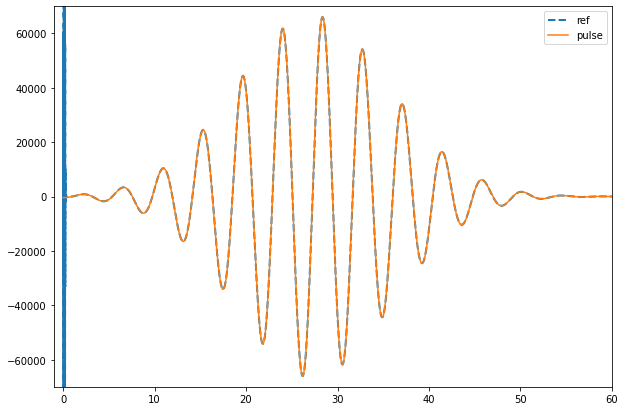

In [90]:
plt.figure(figsize=(10,7))
plt.plot(ref_time,ref_Ex,label='ref',linestyle='--',linewidth=2)
plt.plot(time,pulse,label='pulse')
plt.ylim(-70e3,70e3)
plt.xlim(-1,60)
plt.legend()

### Solution of the Bloch equations.

We use a reference calculation to extract the _initial time_ bloch vectors. We choose t=1 ps as the time value at
which the initial condition is set. In this way the THz pulse start at t=0 in the TLS analysis

In [91]:
ind0 = np.where(time<=1)[0][-1] 
time[ind0]

0.9998750156230471

In [92]:
u_mod0 = u_ref_mod[:,ind0,:]
u_mod0.shape

(3, 48)

In [104]:
uprime = np.zeros([3,ntimes,numk])
delta = energy - de_ccp # in meV
delta_psm1 = delta/h_red # in ps^-1

for k in range(numk):
    uprime0 = u_mod0[:,k]
    mu12 = x_dipole[k,1,0]
    pars = TLS.pulseParametersFromIntensity(mu12,intensity,fwhm=fwhm_THz,THz_pulse=True,verbose=False)
    Omega = lambda t : G.gaussianPulse(t,energy=energy,amplitude=pars['Omega0_abs'],fwhm=fwhm_THz,envelope_only=True,verbose=False)
    uprime[:,:,k] = TLS.solveBlochEq(uprime0,time,Omega,mu12=mu12,delta=delta_psm1)

We rotate the Bloch vector in the original frame

In [105]:
u = np.zeros([3,ntimes,numk])
for k in range(numk):
    u[:,:,k] = TLS.convertToRotatingFrame(omega,time,uprime[:,:,k],invert=True)

time unit: ps
the width parameter of the pulse is 8.493218002880191 ps
Rabi coupling (ps^-1): (0.09624446742322118+0.12766686980545114j)
Rabi coupling (module) (ps^-1): 0.15988066535857767
field amplitude (V/m): 66579.79073343561
pulse area : 3.4037539063785296


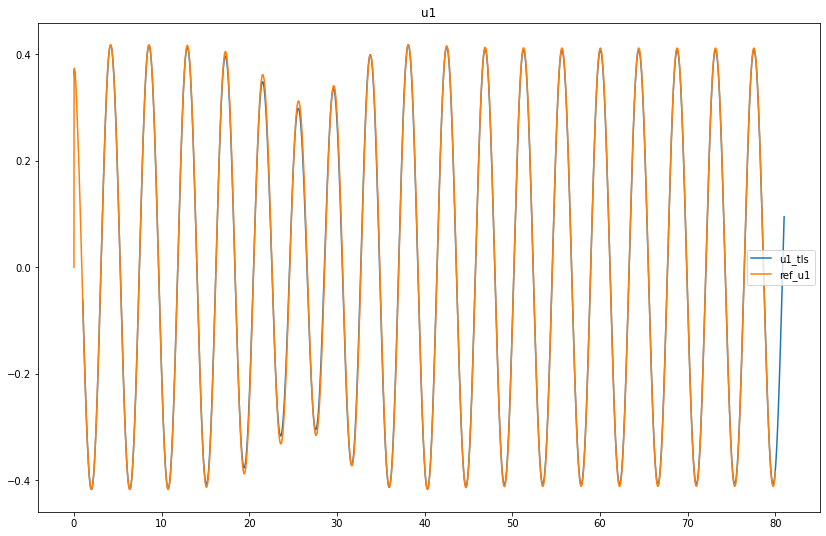

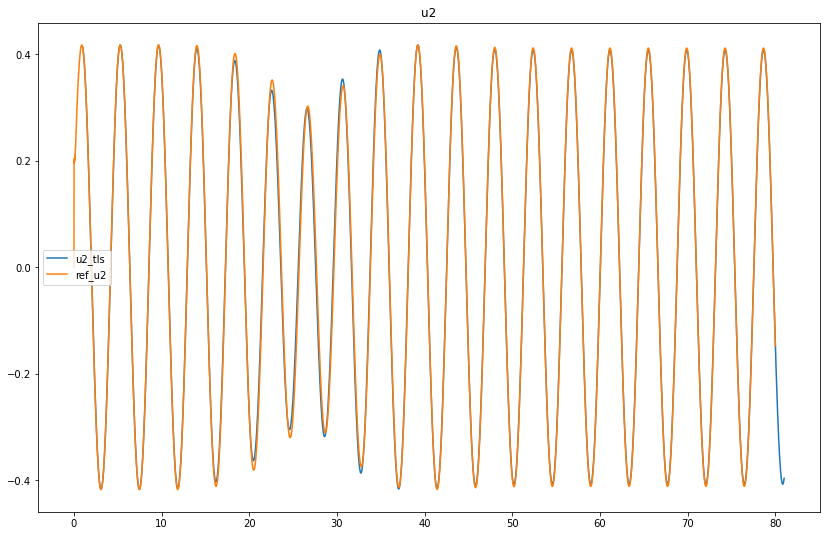

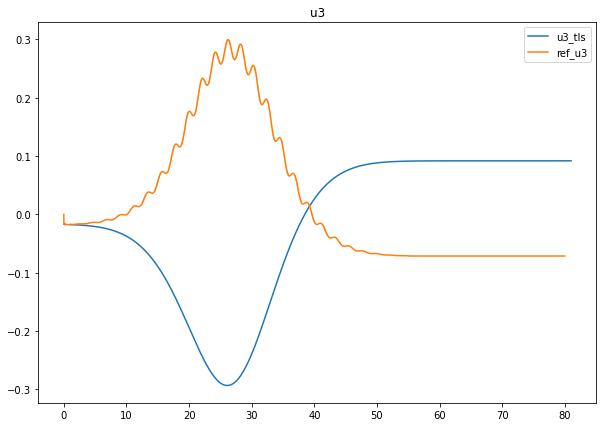

In [120]:
k = 8

pars_k = TLS.pulseParametersFromIntensity(x_dipole[k,0,1],intensity,fwhm=fwhm_THz,THz_pulse=True)

plt.figure(figsize=(14,9))
plt.title('u1')
plt.plot(1+time,u[0,:,k],label='u1_tls')
plt.plot(time,u_ref_mod[0,:,k],label='ref_u1')
plt.legend()
plt.show()

plt.figure(figsize=(14,9))
plt.title('u2')
plt.plot(1+time,u[1,:,k],label='u2_tls')
plt.plot(time,u_ref_mod[1,:,k],label='ref_u2')
plt.legend()
plt.show()

plt.figure(figsize=(10,7))
plt.title('u3')
plt.plot(1+time,u[2,:,k],label='u3_tls')
plt.plot(time,u_ref_mod[2,:,k],label='ref_u3')
plt.legend()
plt.show()

IF WE SET mu12 = x_dipole[k,1,0] in the solution of the Bloch equations we find that u1 and u2 are equal to the references
and u3 is opposite to the reference...FIND WHY!!!!!!!

We can compute the spin polarization obtained in the TLS description and compare it with the reference result.

Since we express the spin polarization in function of the Bloch vector of the TLS we have to apply the transformation that
relate it the one the RT computation, so
$$
Pz = u_1Re(Sz_{10})-u_2Im(Sz_{10})-u_{3}Sz_{00} 
$$

In [121]:
spin_dipole = ref_results.dipoles.spin_dipole(2,first_band=2)
spin_dipole.shape

(48, 2, 2)

In [132]:
Rsz10 = spin_dipole[:,1,0].real
Isz10 = spin_dipole[:,1,0].imag
sz00 = spin_dipole[:,0,0].real
Pz_tls = np.mean(u[0]*Rsz10-u[1]*Isz10-u[2]*sz00,axis=1)

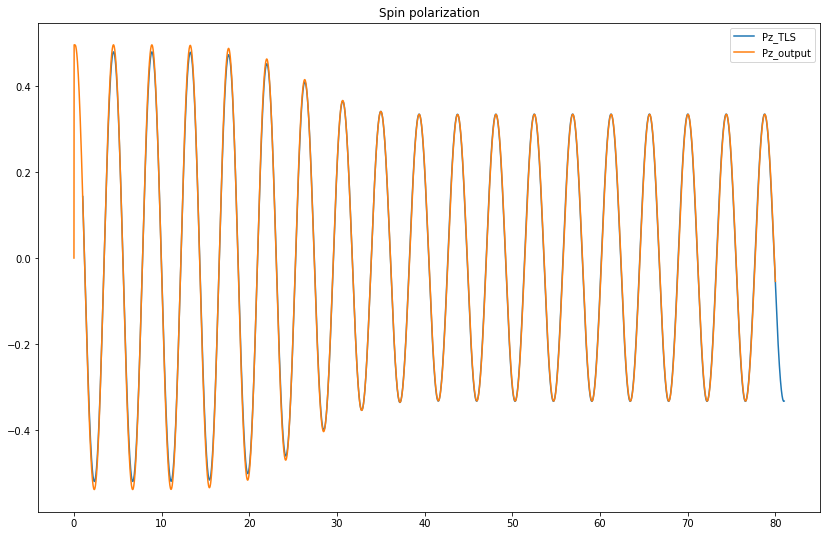

In [133]:
plt.figure(figsize=(14,9))
plt.plot(1+time,Pz_tls,label='Pz_TLS')
plt.plot(ref_time,ref_Pz,label='Pz_output')
plt.title('Spin polarization')
plt.legend()